In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import math

In [4]:
#read in the oradell data
labels = gpd.read_file('data/attributesWithLabels.json')

In [5]:
#drop columns image_capture_date, label_date
labels = labels.drop(['image_capture_date', 'label_date'], axis=1)
#select all missing curb ramps
missing_curb_ramps = labels[labels['label_type'] == 'NoCurbRamp']

In [6]:
missing_curb_ramps

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,heading,pitch,zoom,canvas_x,canvas_y,canvas_width,canvas_height,gsv_url,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_description,user_id,geometry
115,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,458,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,POINT (-74.01831 40.95626)
126,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,429,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,POINT (-74.00311 40.95325)
127,812970,NoCurbRamp,143,11577771,East Oradell,5.0,False,1051,asJJ8iq_xbf5B-8TObLgIw,3.187500,-24.732143,2,360,280,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,POINT (-74.00312 40.95338)
133,812981,NoCurbRamp,48,11569259,East Oradell,5.0,False,1073,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,200,201,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,POINT (-74.01824 40.95627)
134,812967,NoCurbRamp,49,11569259,East Oradell,5.0,False,1075,Rqr_K-nrygOfEInoY7sCkg,139.968750,-10.687500,3,268,253,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,1,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,POINT (-74.01688 40.95597)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11453,812966,NoCurbRamp,49,11569259,East Oradell,5.0,False,12946,6poVHR_8-6agD8xRu99dXQ,85.437500,-7.812500,1,568,275,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,POINT (-74.01719 40.95432)
11454,812968,NoCurbRamp,50,11569259,East Oradell,5.0,False,12947,ZLNvgDCdH0U0CR01hvBPTw,262.250000,-8.062500,1,546,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,POINT (-74.01754 40.95446)
11470,816137,NoCurbRamp,432,629124915,South Oradell,1.0,False,13040,o9ZptmEg7JNnJaPNdj6Djw,94.500000,-32.000000,1,295,207,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,POINT (-74.04188 40.95256)
11473,816142,NoCurbRamp,90,11571794,South Oradell,1.0,False,13043,o9ZptmEg7JNnJaPNdj6Djw,185.555801,-16.437500,3,301,219,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,POINT (-74.04195 40.95246)


In [7]:
#create a dictionary: 1:0.2* -0.25, 2:0.4* -0.25, 3:0.6* -0.25, 4:0.8* -0.25, 5:1.0* -0.25
dict_weight = {1:0.2* -0.25, 2:0.4* -0.25, 3:0.6* -0.25, 4:0.8* -0.25, 5:1.0* -0.25}

In [8]:
#replace nan with 1
missing_curb_ramps['label_severity'] = missing_curb_ramps['label_severity'].fillna(1)

In [9]:
#create a new column called weighted_scored and apply the dictinry on label_severity
missing_curb_ramps['weighted_score'] = missing_curb_ramps['label_severity'].apply(lambda x: dict_weight[x])

In [12]:
weighted_score = missing_curb_ramps[['attribute_id','weighted_score']]

In [13]:
weighted_score 

,attribute_id,weighted_score
115,812977,-0.25
126,812984,-0.25
127,812970,-0.25
133,812981,-0.25
134,812967,-0.25
...,...,...
11453,812966,-0.25
11454,812968,-0.25
11470,816137,-0.05
11473,816142,-0.05


In [10]:
#read in missing curb ramps geojson file
url = gpd.read_file('data/missing_curb_ramps.geojson')
url

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,heading,pitch,zoom,canvas_x,canvas_y,canvas_width,canvas_height,gsv_url,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_description,user_id,img_url,geometry
0,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626)
1,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325)
2,812970,NoCurbRamp,143,11577771,East Oradell,5.0,False,1051,asJJ8iq_xbf5B-8TObLgIw,3.187500,-24.732143,2,320,280,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1051.jpg,POINT (-74.00312 40.95338)
3,812981,NoCurbRamp,48,11569259,East Oradell,5.0,False,1073,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,177,201,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1073.jpg,POINT (-74.01824 40.95627)
4,812967,NoCurbRamp,49,11569259,East Oradell,5.0,False,1075,Rqr_K-nrygOfEInoY7sCkg,139.968750,-10.687500,3,238,253,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,1,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1075.jpg,POINT (-74.01688 40.95597)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,812966,NoCurbRamp,49,11569259,East Oradell,5.0,False,12946,6poVHR_8-6agD8xRu99dXQ,85.437500,-7.812500,1,504,275,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,img/with-icons/no-curb-ramps/label_id_12946.jpg,POINT (-74.01719 40.95432)
541,812968,NoCurbRamp,50,11569259,East Oradell,5.0,False,12947,ZLNvgDCdH0U0CR01hvBPTw,262.250000,-8.062500,1,485,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,img/with-icons/no-curb-ramps/label_id_12947.jpg,POINT (-74.01754 40.95446)
542,816137,NoCurbRamp,432,629124915,South Oradell,1.0,False,13040,o9ZptmEg7JNnJaPNdj6Djw,94.500000,-32.000000,1,262,207,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,img/with-icons/no-curb-ramps/label_id_13040.jpg,POINT (-74.04188 40.95256)
543,816142,NoCurbRamp,90,11571794,South Oradell,1.0,False,13043,o9ZptmEg7JNnJaPNdj6Djw,185.555801,-16.437500,3,267,219,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,img/with-icons/no-curb-ramps/label_id_13043.jpg,POINT (-74.04195 40.95246)


In [14]:
#merge the weighted_score with the url on attribute_id
points = pd.merge(url, weighted_score, on='attribute_id', how='left')
points

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,heading,pitch,zoom,canvas_x,canvas_y,canvas_width,canvas_height,gsv_url,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_description,user_id,img_url,geometry,weighted_score
0,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
1,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
2,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
3,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
4,812970,NoCurbRamp,143,11577771,East Oradell,5.0,False,1051,asJJ8iq_xbf5B-8TObLgIw,3.187500,-24.732143,2,320,280,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1051.jpg,POINT (-74.00312 40.95338),-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,812968,NoCurbRamp,50,11569259,East Oradell,5.0,False,12947,ZLNvgDCdH0U0CR01hvBPTw,262.250000,-8.062500,1,485,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,img/with-icons/no-curb-ramps/label_id_12947.jpg,POINT (-74.01754 40.95446),-0.25
903,812968,NoCurbRamp,50,11569259,East Oradell,5.0,False,12947,ZLNvgDCdH0U0CR01hvBPTw,262.250000,-8.062500,1,485,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,1,0,0,None,386a4e0d-48c7-46a0-b780-9b543067ffd8,img/with-icons/no-curb-ramps/label_id_12947.jpg,POINT (-74.01754 40.95446),-0.25
904,816137,NoCurbRamp,432,629124915,South Oradell,1.0,False,13040,o9ZptmEg7JNnJaPNdj6Djw,94.500000,-32.000000,1,262,207,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,img/with-icons/no-curb-ramps/label_id_13040.jpg,POINT (-74.04188 40.95256),-0.05
905,816142,NoCurbRamp,90,11571794,South Oradell,1.0,False,13043,o9ZptmEg7JNnJaPNdj6Djw,185.555801,-16.437500,3,267,219,720,480,https://maps.googleapis.com/maps/api/streetvie...,1.0,False,0,0,0,None,ce60454f-5d40-4649-a17a-562a46c57519,img/with-icons/no-curb-ramps/label_id_13043.jpg,POINT (-74.04195 40.95246),-0.05


In [15]:
points.head()

,attribute_id,label_type,street_edge_id,osm_street_id,neighborhood,severity,is_temporary,label_id,gsv_panorama_id,heading,pitch,zoom,canvas_x,canvas_y,canvas_width,canvas_height,gsv_url,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,label_description,user_id,img_url,geometry,weighted_score
0,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
1,812977,NoCurbRamp,48,11569259,East Oradell,5.0,False,1072,G7wPVt3wuJV2ARSBqWyiZQ,121.765625,-3.515625,3,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
2,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
3,812984,NoCurbRamp,282,11585828,East Oradell,5.0,False,1050,asJJ8iq_xbf5B-8TObLgIw,166.758926,-12.107142,2,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,2,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
4,812970,NoCurbRamp,143,11577771,East Oradell,5.0,False,1051,asJJ8iq_xbf5B-8TObLgIw,3.187500,-24.732143,2,320,280,720,480,https://maps.googleapis.com/maps/api/streetvie...,5.0,False,3,0,0,None,2d7e45f5-3656-4aae-9a09-14addfa80d22,img/with-icons/no-curb-ramps/label_id_1051.jpg,POINT (-74.00312 40.95338),-0.25


In [17]:
#drop osm_edge_id, neighborhood, is_temporary, gsv_panorama_id, heading, pitch, zoom, label_severity, label_is_temporary, agree_count, disagree_count,	notsure_count, label_description, user_id
points = points.drop(['osm_street_id', 'neighborhood', 'is_temporary', 'gsv_panorama_id', 'heading', 'pitch', 'zoom', 'label_severity', 'label_is_temporary', 'agree_count', 'disagree_count','notsure_count', 'label_description', 'user_id'], axis=1)
points

,attribute_id,label_type,street_edge_id,severity,label_id,canvas_x,canvas_y,canvas_width,canvas_height,gsv_url,img_url,geometry,weighted_score
0,812977,NoCurbRamp,48,5.0,1072,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
1,812977,NoCurbRamp,48,5.0,1072,407,308,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_1072.jpg,POINT (-74.01831 40.95626),-0.25
2,812984,NoCurbRamp,282,5.0,1050,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
3,812984,NoCurbRamp,282,5.0,1050,381,273,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_1050.jpg,POINT (-74.00311 40.95325),-0.25
4,812970,NoCurbRamp,143,5.0,1051,320,280,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_1051.jpg,POINT (-74.00312 40.95338),-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,812968,NoCurbRamp,50,5.0,12947,485,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_12947.jpg,POINT (-74.01754 40.95446),-0.25
903,812968,NoCurbRamp,50,5.0,12947,485,263,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_12947.jpg,POINT (-74.01754 40.95446),-0.25
904,816137,NoCurbRamp,432,1.0,13040,262,207,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_13040.jpg,POINT (-74.04188 40.95256),-0.05
905,816142,NoCurbRamp,90,1.0,13043,267,219,720,480,https://maps.googleapis.com/maps/api/streetvie...,img/with-icons/no-curb-ramps/label_id_13043.jpg,POINT (-74.04195 40.95246),-0.05


In [18]:
points.to_file('data/points_full.geojson', driver='GeoJSON')

In [ ]:
missing_curb_ramps

In [32]:
#group by street_edge_id and reset index
missing_curb_ramps = missing_curb_ramps.groupby('street_edge_id').sum().reset_index()

,street_edge_id,attribute_id,osm_street_id,severity,is_temporary,label_id,heading,pitch,zoom,canvas_x,canvas_y,canvas_width,canvas_height,label_severity,label_is_temporary,agree_count,disagree_count,notsure_count,weighted_score
0,1,1632315,23124594,10.0,0,149,224.312500,-47.941963,2,774,463,1440,960,10.0,0,11,1,0,-0.50
1,3,8161462,115641270,45.0,0,17133,2246.751717,-146.593213,18,4227,2425,7200,4800,45.0,0,48,10,1,-2.25
2,5,3264584,46258124,17.0,0,13251,391.354908,-63.504465,8,1369,745,2880,1920,17.0,0,17,1,0,-0.85
3,6,4896936,69387186,30.0,0,24737,1060.276790,-115.859375,9,2488,1278,4320,2880,30.0,0,23,2,0,-1.50
4,8,2448417,34694508,15.0,0,7209,463.754452,-80.437500,3,1191,612,2160,1440,14.0,0,8,3,2,-0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,475,2454173,2090323536,11.0,0,17979,500.611620,-43.290178,5,1248,673,2160,1440,11.0,0,3,0,1,-0.55
208,476,818029,696774512,0.0,0,3791,16.937500,-14.500000,1,595,211,720,480,1.0,0,2,0,0,-0.05
209,477,1636052,1393549024,10.0,0,7719,53.247499,-39.937500,2,136,513,1440,960,10.0,0,4,0,0,-0.50
210,478,812978,697833281,5.0,0,681,92.131432,-19.625000,1,275,265,720,480,5.0,0,6,1,0,-0.25


In [33]:
#select only street_edge_id and weighted_score
missing_curb_ramps = missing_curb_ramps[['street_edge_id', 'weighted_score']]
missing_curb_ramps

,street_edge_id,weighted_score
0,1,-0.50
1,3,-2.25
2,5,-0.85
3,6,-1.50
4,8,-0.70
...,...,...
207,475,-0.55
208,476,-0.05
209,477,-0.50
210,478,-0.25


In [35]:
#replace values lower than -1 with -1
missing_curb_ramps['weighted_score'] = missing_curb_ramps['weighted_score'].apply(lambda x: -1 if x < -1 else x)


<AxesSubplot: >

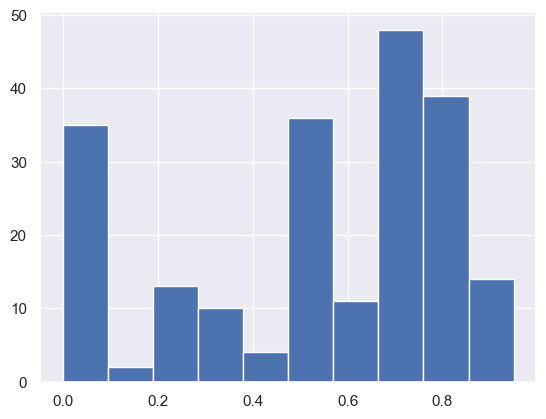

In [39]:
#histogram of weighted_score
missing_curb_ramps['street_access_score'].hist()

In [38]:
# add a column called street access score = 1- weighted_score
missing_curb_ramps['street_access_score'] = 1 + missing_curb_ramps['weighted_score']
missing_curb_ramps

,street_edge_id,weighted_score,street_access_score
0,1,-0.50,0.50
1,3,-1.00,0.00
2,5,-0.85,0.15
3,6,-1.00,0.00
4,8,-0.70,0.30
...,...,...,...
207,475,-0.55,0.45
208,476,-0.05,0.95
209,477,-0.50,0.50
210,478,-0.25,0.75


In [40]:
#sort by street_access_score
missing_curb_ramps = missing_curb_ramps.sort_values(by=['street_access_score'], ascending=False)
missing_curb_ramps

,street_edge_id,weighted_score,street_access_score
211,492,-0.05,0.95
26,90,-0.05,0.95
166,392,-0.05,0.95
63,157,-0.05,0.95
167,394,-0.05,0.95
...,...,...,...
89,225,-1.00,0.00
186,430,-1.00,0.00
92,233,-1.00,0.00
102,254,-1.00,0.00


In [48]:
#read in street_full.json 
street_full = gpd.read_file('data/streets_full.geojson')
street_full

,street_edge_id,no_curbs_count,geometry
0,477,1.0,"LINESTRING (-74.03435 40.95815, -74.03432 40.9..."
1,394,1.0,"LINESTRING (-74.03803 40.96224, -74.03847 40.9..."
2,272,2.0,"LINESTRING (-74.03927 40.94984, -74.04012 40.9..."
3,350,1.0,"LINESTRING (-74.04447 40.95864, -74.04676 40.9..."
4,424,1.0,"LINESTRING (-74.03408 40.94548, -74.03377 40.9..."
...,...,...,...
207,25,1.0,"LINESTRING (-74.03267 40.94202, -74.03249 40.9..."
208,141,1.0,"LINESTRING (-74.01383 40.95258, -74.01389 40.9..."
209,94,4.0,"LINESTRING (-74.03519 40.96667, -74.03599 40.9..."
210,49,4.0,"LINESTRING (-74.01821 40.95627, -74.01698 40.9..."


In [49]:
# merge street_full and missing_curb_ramps on street_edge_id
street_full = street_full.merge(missing_curb_ramps, on='street_edge_id', how='right')
street_full

,street_edge_id,no_curbs_count,geometry,weighted_score,street_access_score
0,492,1.0,"LINESTRING (-74.02980 40.94235, -74.02957 40.9...",-0.05,0.95
1,90,1.0,"LINESTRING (-74.04267 40.95076, -74.04187 40.9...",-0.05,0.95
2,392,1.0,"LINESTRING (-74.03501 40.95517, -74.03631 40.9...",-0.05,0.95
3,157,1.0,"LINESTRING (-74.03601 40.95876, -74.03586 40.9...",-0.05,0.95
4,394,1.0,"LINESTRING (-74.03803 40.96224, -74.03847 40.9...",-0.05,0.95
...,...,...,...,...,...
207,225,4.0,"LINESTRING (-74.03582 40.96311, -74.03562 40.9...",-1.00,0.00
208,430,4.0,"LINESTRING (-74.04265 40.95310, -74.04262 40.9...",-1.00,0.00
209,233,4.0,"LINESTRING (-74.02048 40.95618, -74.01959 40.9...",-1.00,0.00
210,254,4.0,"LINESTRING (-74.02180 40.95188, -74.02179 40.9...",-1.00,0.00


In [50]:
#drop weighted_score and move geometry to the end
street_full = street_full.drop(['weighted_score'], axis=1)
street_full = street_full[['street_edge_id','no_curbs_count','street_access_score', 'geometry']]
street_full

,street_edge_id,no_curbs_count,street_access_score,geometry
0,492,1.0,0.95,"LINESTRING (-74.02980 40.94235, -74.02957 40.9..."
1,90,1.0,0.95,"LINESTRING (-74.04267 40.95076, -74.04187 40.9..."
2,392,1.0,0.95,"LINESTRING (-74.03501 40.95517, -74.03631 40.9..."
3,157,1.0,0.95,"LINESTRING (-74.03601 40.95876, -74.03586 40.9..."
4,394,1.0,0.95,"LINESTRING (-74.03803 40.96224, -74.03847 40.9..."
...,...,...,...,...
207,225,4.0,0.00,"LINESTRING (-74.03582 40.96311, -74.03562 40.9..."
208,430,4.0,0.00,"LINESTRING (-74.04265 40.95310, -74.04262 40.9..."
209,233,4.0,0.00,"LINESTRING (-74.02048 40.95618, -74.01959 40.9..."
210,254,4.0,0.00,"LINESTRING (-74.02180 40.95188, -74.02179 40.9..."


In [57]:
#find street edge_id ==48
street_full[street_full['street_edge_id'] == 48]


,street_edge_id,no_curbs_count,street_access_score,geometry
162,48,2.0,0.25,"LINESTRING (-74.01935 40.95648, -74.01821 40.9..."


In [68]:
street_full.explore(column ='street_access_score', cmap='RdYlGn', tiles='cartodbpositron')

In [55]:
#export to geojson
street_full.to_file('data/streets_full.geojson', driver='GeoJSON')
